本教程是使用决策树和`tf.estimator`API 训练Gradient Boosting模型的端到端演练。Boosted Trees模型是回归和分类中最受欢迎和最有效的机器学习方法之一。这是一种集合技术，它结合了几种（认为10s，100s甚至1000s）树模型的预测。

Boosted Trees模型在许多机器学习实践中很受欢迎，因为它们可以通过最小的超参数调整实现令人印象深刻的性能。

##### 加载泰坦尼克号数据集
您将使用泰坦尼克数据集，其中（相当病态）的目标是预测乘客的生存，给出性别，年龄，等级等特征。

In [1]:
from __future__ import absolute_import,division,print_function

import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# Load dataset 
dftrain = pd.read_csv('data/titanic_train.csv')
dfeval = pd.read_csv('data/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

数据集由训练集和评估集组成：

- dftrain并且y_train是训练集 - 模型用于学习的数据。
- 该模型对测试EVAL集，dfeval和y_eval。
对于培训，您将使用以下功能：

| 功能名称 | 描述 |
|:--------|-----:|
|性别	|乘客的性别|
|年龄	|乘客年龄|
|n_siblings_spouses	|＃兄弟姐妹和合作伙伴|
|胹	|船上的父母和孩子的数量|
|票价	|支付票价乘客。|
|类	|乘客在船上的班级|
|甲板	|哪个甲板乘客上了|
|embark_town	|哪个城镇的乘客从哪里出发|
|单独	|如果乘客一个人|

#### 探索数据
让我们首先预览一些数据，并在训练集上创建摘要统计。

In [2]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [3]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


培训和评估集分别有627和264个例子。

In [4]:
dftrain.shape[0],dfeval.shape[0]

(627, 264)

大多数乘客都在20和30年代。

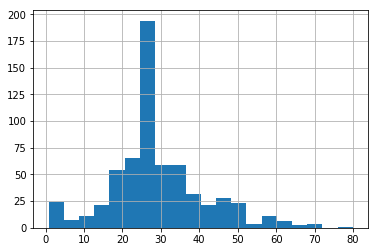

In [6]:
dftrain.age.hist(bins=20);

男乘客大约是女乘客的两倍。

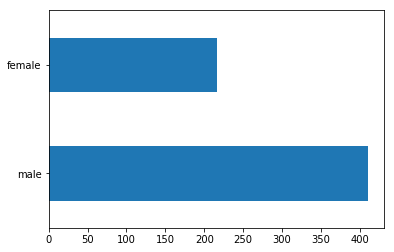

In [7]:
dftrain.sex.value_counts().plot(kind='barh');

大多数乘客都在“第三”班。

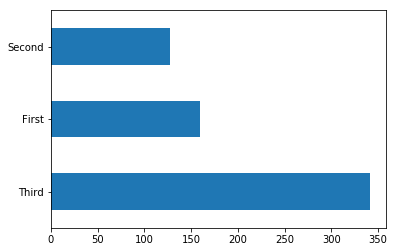

In [8]:
(dftrain['class'].value_counts().plot(kind='barh'));

与男性相比，女性存活的机率要高得多。这显然是该模型的预测特征。

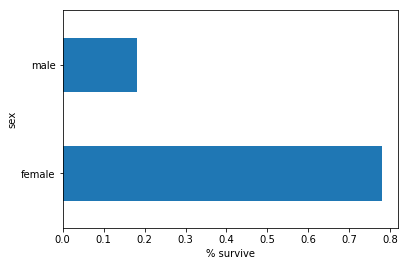

In [10]:
ax = (pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh'))
ax.set_xlabel('% survive');

###### 创建要素列和输入函数
Gradient Boosting估算器可以使用数字和分类功能。功能列适用于所有TensorFlow估算器，其目的是定义用于建模的功能。此外，它们还提供了一些功能工程功能，如单热编码，规范化和bucketization。在本教程中，字段CATEGORICAL_COLUMNS从分类列转换为单热编码列（指标列）：

In [11]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name,vocab):
    return fc.indicator_column(
                fc.categorical_column_with_vocabulary_list(feature_name,vocab))

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name,vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,dtype=tf.float32))

您可以查看要素列生成的转换。例如，以下是使用indicator_column单个示例时的输出：

In [12]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class',('First','Second','Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ',fc.input_layer(dict(example),[class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


此外，您还可以一起查看所有要素列转换：

In [13]:
fc.input_layer(dict(example),feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

接下来，您需要创建输入函数。这些将指定如何将数据读入我们的模型以进行训练和推理。您将使用该`from_tensor_slices`方法`tf.data`用于直接从Pandas读取数据的API。这适用于较小的内存数据集。对于较大的数据集，tf.data API支持各种文件格式（包括csv），以便您可以处理不适合内存的数据集

In [14]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X,y,n_epochs=None,shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X),y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
            
        dataset=dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(dftrain,y_train)
eval_input_fn = make_input_fn(dfeval,y_eval,shuffle=False,n_epochs=1)

##### 训练和评估模型
您将在下面执行以下步骤：

1. 初始化模型，指定要素和超参数。
2. train_input_fn使用该train功能将训练数据输入模型并训练模型。
3. 您将使用评估集（在此示例中为dfevalDataFrame）评估模型性能。您将验证预测是否与y_eval阵列中的标签匹配。

在训练Boosted Trees模型之前，让我们首先训练一个线性分类器（逻辑回归模型）。最好的做法是从更简单的模型开始建立基准。

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(train_input_fn,max_steps=100)

results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ',results['accuracy'])
print('Dummy model: ',results['accuracy_baseline'])

Accuracy :  0.70075756
Dummy model:  0.625


接下来让我们训练一下Boosted Trees模型。对于增强树，支持regression（`BoostedTreesRegressor`）和classification（`BoostedTreesClassifier`），以及使用任何两次可微分自定义丢失（`BoostedTreesEstimator`）。由于目标是预测一个阶级 - 生存或不生存，你将使用`BoostedTreesClassifier`。

In [20]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.8219697
Dummy model:  0.625


出于性能原因，当您的数据适合内存时，建议使用该boosted_trees_classifier_train_in_memory功能。但是，如果培训时间不是问题，或者您拥有非常大的数据集并且想要进行分布式培训，请使用tf.estimator.BoostedTrees上面显示的API。

使用此方法时，不应批量输入数据，因为该方法对整个数据集进行操作。